In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const

pi = np.pi
BIGG = const.G.value
MSUN = const.M_sun.value
AU = const.au.value
OUMUAMUA_COORDS = [np.radians(279.804-360.), np.radians(33.997)]

THETA = np.radians(122.932)                    
ANGP = np.radians(192.859508)
DNGP = np.radians(27.128336)

# Read in text files

In [2]:
MAINPATH = 'distribution_function/'
vel = np.loadtxt(MAINPATH + 'vgal.txt')           # already galactic velocities, with respect to Sun             
                                                  # subtracting VSUN is unecessary
NSAMPLES = len(vel)

In [3]:
T1 = [[np.cos(THETA), np.sin(THETA), 0.], [np.sin(THETA), -np.cos(THETA), 0.], [0., 0., 1.]]    
T2 = [[-np.sin(DNGP), 0., np.cos(DNGP)], [0., 1., 0.], [np.cos(DNGP), 0., np.sin(DNGP)]]        
T3 = [[np.cos(ANGP), np.sin(ANGP), 0.], [-np.sin(ANGP), np.cos(ANGP), 0.], [0., 0., 1.]]

T = np.matmul(np.matmul(T1, T2), T3)                                                       
                                                                                           
def get_ra_dec(R):
    R = np.matmul(np.linalg.inv(T), R)
    mag = np.linalg.norm(R)
    dec = np.arcsin(R[2]/mag)
    if R[1]/mag > 0:
        ra = np.arccos(R[0]/(mag*np.cos(dec)))
    else:
        ra = 2*pi-np.arccos(R[0]/(mag*np.cos(dec)))
    if ra > pi:
        ra = ra - 2*pi
    return np.asarray([ra, dec])

pos = np.zeros((NSAMPLES, 2))
for i, v in enumerate(vel):
    pos[i] = get_ra_dec(-v)           

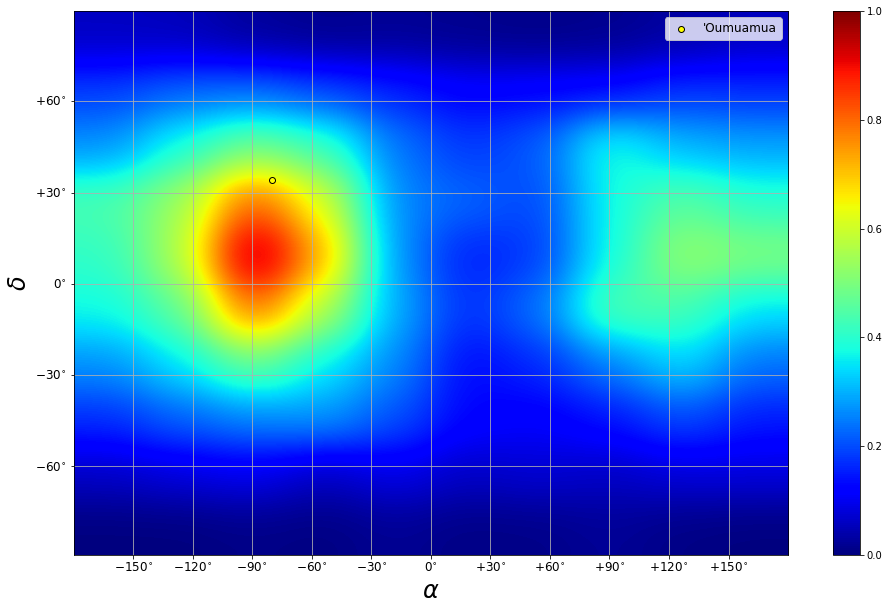

In [4]:
plt.figure(figsize=(16, 10))

H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=10)
plt.imshow(H.transpose()[::-1], extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='gaussian', aspect='auto', \
           cmap='jet')

plt.xlabel(r'$\alpha$', fontsize=24)
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          fontsize=12)

plt.ylabel(r'$\delta$', fontsize=24)
plt.yticks([-pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2], [r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', \
        r'$0^{\circ}$', r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$'], fontsize=12)
plt.grid(True)

plt.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', label="'Oumuamua")
plt.legend(loc='upper right', fontsize=12)
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='jet'))

plt.show()

# Draw b and $\psi$

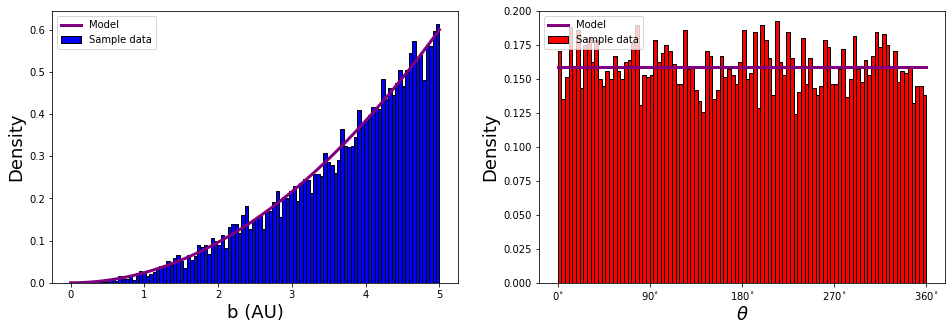

In [5]:
A = 0.                                                     
B = 5.

def sample_b_dist(N=NSAMPLES, a=0, b=5):                  
    P = np.random.uniform(size=N)
    return (P*(b**3-a**3) + a**3)**(1/3)

b = sample_b_dist(a=A, b=B)
psi = np.random.uniform(low=0, high=2*pi, size=NSAMPLES)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
ax1 = axes[0]
ax1.hist(b, color='blue', edgecolor='k', bins=100, density=True, label='Sample data')
x = np.linspace(A, B, 1000)
ax1.plot(x, 3*x**2/(B**3-A**3), c='purple', lw=3, label='Model')                         
ax1.set_xlabel('b (AU)', fontsize=18)
ax1.set_ylabel('Density', fontsize=18)
ax1.legend(loc='upper left', fontsize=10)

ax2 = axes[1]
ax2.hist(psi, color='red', edgecolor='k', bins=100, density=True, label='Sample data')
ax2.plot(np.linspace(0, 2*pi, 1000), np.repeat([1/(2*pi)], 1000), c='purple', lw=3, label='Model')  
ax2.set_xlabel(r'$\theta$', fontsize=18)
ax2.set_xticks([0, pi/2, pi, 3*pi/2, 2*pi])
ax2.set_xticklabels([r'$0^{\circ}$', r'$90^{\circ}$', r'$180^{\circ}$', r'$270^{\circ}$', r'$360^{\circ}$'])
ax2.set_ylabel('Density', fontsize=18)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_ylim(0, 0.2)

plt.show()

# Get initial R vectors

In [6]:
RSKY = 5. 
VESC = np.sqrt(2*BIGG*MSUN/(RSKY*AU))/1000

for i, v in enumerate(vel):
    vel[i] = np.sqrt(np.linalg.norm(v)**2 + VESC**2)/np.linalg.norm(v)

In [7]:
R = np.zeros((NSAMPLES, 3))
b_vec = np.zeros_like(R)
R_sky = np.zeros_like(R)

for i, v in enumerate(vel):
    R_sky[i] = -np.sqrt(RSKY**2-b[i]**2)*v/np.linalg.norm(v)
    phi = np.arctan(-(np.cos(psi[i])*v[0] + np.sin(psi[i])*v[1])/v[2])
    b_vec[i] = np.array([b[i]*np.cos(phi)*np.cos(psi[i]), b[i]*np.cos(phi)*np.sin(psi[i]), \
                         b[i]*np.sin(phi)])
    R[i] = R_sky[i] + b_vec[i]

# Run simulations using REBOUND

In [8]:
import rebound

NTIMES = 100
INTEGRATION_TIME = 3.*365.*24.*60.*60. 

sim = rebound.Simulation()
sim.units = ('s', 'm', 'kg')
sim.add('Sun')
sim.add('Earth')
sim.save('ss.bin')

def integrate(R, v):
    sim = rebound.Simulation('ss.bin')
    sim.add(x=R[0]*AU, y=R[1]*AU, z=R[2]*AU, vx=v[0]*1000., vy=v[1]*1000., vz=v[2]*1000.)
    
    ps = sim.particles
    times = np.linspace(0, INTEGRATION_TIME, NTIMES)
    distances = np.zeros_like(times)
    a = np.zeros_like(times)
    e = np.zeros_like(times)
    
    for i, t in enumerate(times):
        sim.integrate(t)
        dp = ps[2] - ps[1]
        distances[i] = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
        orbit = sim.particles[-1].calculate_orbit()
        a[i] = orbit.a
        e[i] = orbit.e
        
    orbit_data = {}
    orbit_data['times'] = times
    orbit_data['dist'] = distances
    orbit_data['a'] = a
    orbit_data['e'] = e
    
    return orbit_data 

def dist_closest_encounter(R, v):
    orbit_data = integrate(R, v)
    return np.min(orbit_data['dist'])/AU

def plot_orbit_evolution(R, v):
    orbit_data = integrate(R, v)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    ax = axes[0]
    ax.plot(orbit_data['times']/(365*24*60*60), orbit_data['a']/AU, c='blue')
    
    ax = axes[1]
    ax.plot(orbit_data['times']/(365*24*60*60), orbit_data['e'], c='red')
    
    plt.show()

Searching NASA Horizons for 'Sun'... Found: Target body name: Sun (10).
Searching NASA Horizons for 'Earth'... Found: Target body name: Earth-Moon Barycenter (3).


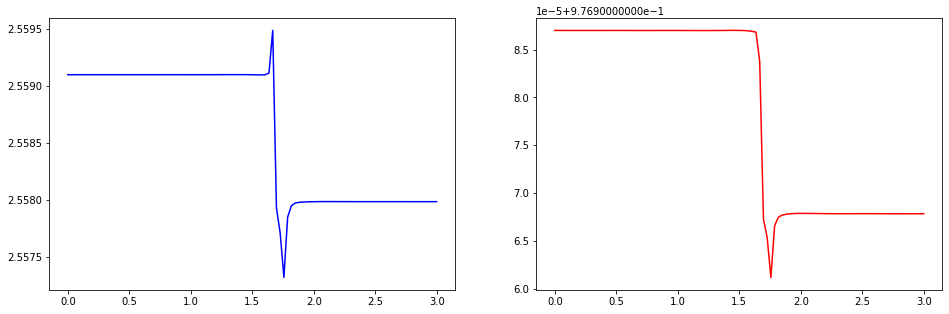

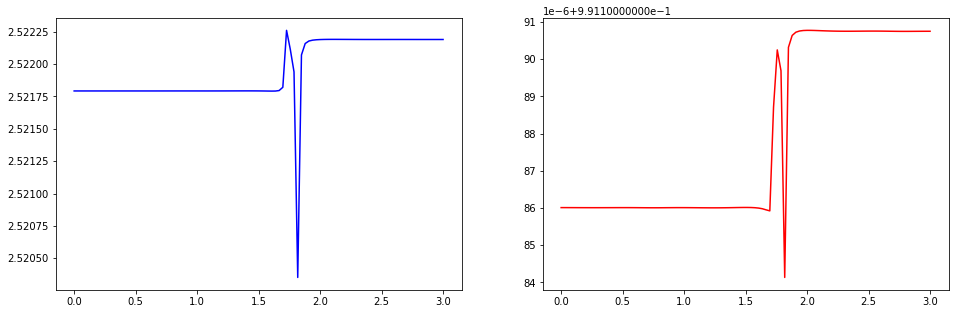

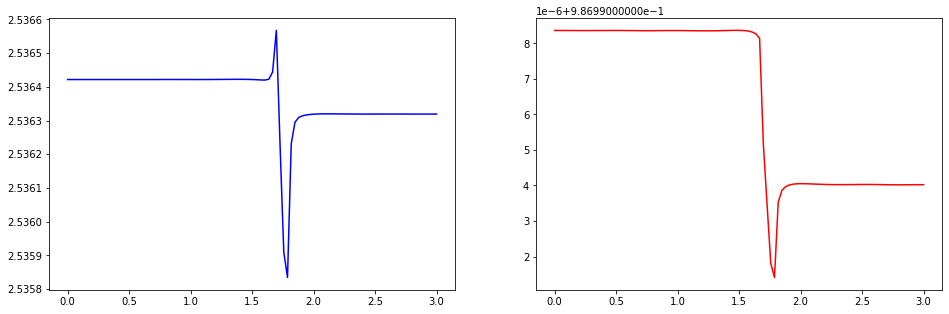

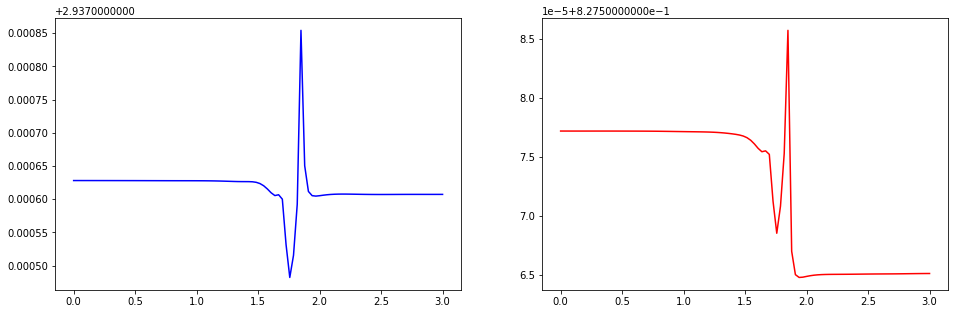

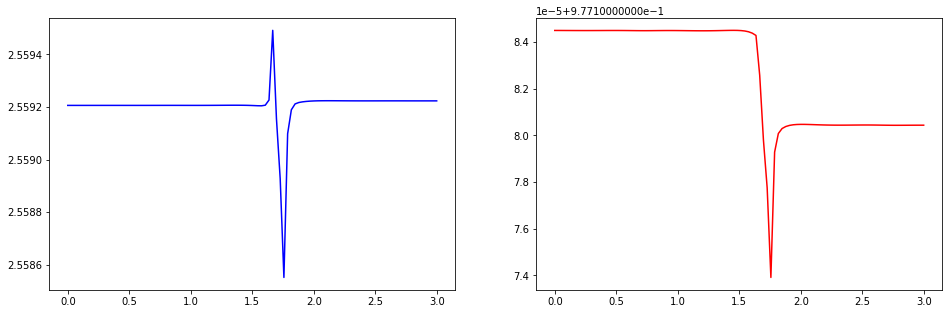

# Close encounters: 0.050 %


In [9]:
min_distances = np.zeros(NSAMPLES)
for i, d in enumerate(min_distances):
    min_distances[i] = dist_closest_encounter(R[i], vel[i])
    if min_distances[i] <= 0.1:
        plot_orbit_evolution(R[i], vel[i])
    
frac_close_encounter = len(min_distances[min_distances <= 0.1])/len(min_distances)
print('# Close encounters: %.3f %%' %(frac_close_encounter*100))